In [11]:
import requests
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import gamma
import numpy as np
from functools import reduce
#import c3aidatalake
import seaborn as sns

# At least for this EDA, let's just look at Georgia

ignore this bc it was way easier to get/format data straight from us census
ga_dem = c3aidatalake.fetch(
    'populationdata',
    {"spec": {
       "filter": "contains(parent, 'Georgia') && year == 2010 && estimate == 'False'"
        
    }},
    get_all = True
)
ga_dem.head()

In [2]:
ga_dem = pd.read_csv('../../data/demographics/georgia_county_dem.csv')
ga_dem['parent.id'] = ga_dem.apply(lambda x: x['CTYNAME'].split(' County')[0] + '_' + x['STNAME'] + '_UnitedStates', axis=1)
ga_dem = ga_dem[ga_dem['YEAR']==1]
year_desc = {0: 'Total'
,1: '0-4'
,2 : '5-9'
,3 : '10-14'
,4 : '15-19'
,5 : '20-24'
,6 : '25-29'
,7 : '30-34'
,8 : '35-39'
,9 : '40-44'
,10 : '45-49'
,11 : '50-54'
,12 : '55-59'
,13 : '60-64'
,14 : '65-69'
,15 : '70-74'
,16 : '75-79'
,17 : '80-84'
,18 : '85_plus'}
ga_dem['AGEGRP'] = ga_dem['AGEGRP'].replace(year_desc)
ga_dem.head()

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,...,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE,parent.id
0,50,13,1,Georgia,Appling County,1,Total,18236,9159,9077,...,621,48,42,21,26,6,4,24,0,Appling_Georgia_UnitedStates
1,50,13,1,Georgia,Appling County,1,0-4,1306,647,659,...,106,7,7,3,3,1,0,1,0,Appling_Georgia_UnitedStates
2,50,13,1,Georgia,Appling County,1,5-9,1286,658,628,...,78,6,5,2,4,1,0,1,0,Appling_Georgia_UnitedStates
3,50,13,1,Georgia,Appling County,1,10-14,1331,703,628,...,63,1,7,3,2,1,1,4,0,Appling_Georgia_UnitedStates
4,50,13,1,Georgia,Appling County,1,15-19,1254,691,563,...,58,8,3,0,4,0,0,3,0,Appling_Georgia_UnitedStates


In [3]:
def get_JHU(column):
    today = pd.Timestamp.now().strftime("%Y-%m-%d")
    rst = c3aidatalake.evalmetrics(
        "outbreaklocation",
        {
            "spec" : {
                "filter": "contains(id, 'Georgia')",
                "expressions" : [column],
                "start" : today,
                "end" : today,
                "interval" : "DAY",
            }
        }
    )
    rst = rst.filter(regex=("\.data")).melt()
    rst["parent.id"] = rst['variable'].apply(lambda x: x.split('.')[0])
    del rst['variable']
    rst = rst.rename(columns={'value': column})
    rst.head()
    return rst

In [4]:
dem_data = [ga_dem]

In [5]:
cases = get_JHU('JHU_ConfirmedCases')
dem_data.append(cases)
cases.head()

,JHU_ConfirmedCases,parent.id
0,440,Johnson_Georgia_UnitedStates
1,210,Heard_Georgia_UnitedStates
2,2012,Rockdale_Georgia_UnitedStates
3,1826,Habersham_Georgia_UnitedStates
4,1187,Liberty_Georgia_UnitedStates


In [6]:
deaths = get_JHU('JHU_ConfirmedDeaths')
dem_data.append(deaths)
deaths.head()

,JHU_ConfirmedDeaths,parent.id
0,22,Johnson_Georgia_UnitedStates
1,6,Heard_Georgia_UnitedStates
2,40,Rockdale_Georgia_UnitedStates
3,74,Habersham_Georgia_UnitedStates
4,24,Liberty_Georgia_UnitedStates


In [7]:
recs = get_JHU('JHU_ConfirmedRecoveries')
dem_data.append(recs)
recs.head()

,JHU_ConfirmedRecoveries,parent.id
0,0,Johnson_Georgia_UnitedStates
1,0,Heard_Georgia_UnitedStates
2,0,Rockdale_Georgia_UnitedStates
3,0,Habersham_Georgia_UnitedStates
4,0,Liberty_Georgia_UnitedStates


In [18]:
ga = reduce(lambda left,right: pd.merge(left, right, on=['parent.id']), dem_data)
#ga = ga.drop(['year','gender','race','ethnicity','estimate','median'
#              ,'percent','minAge','maxAge','origin'
#             ,'timestamp', 'populationAge'],axis=1)
#ga['id'] = ga['id'].apply(lambda x: x.split('Male/Female_')[1])
#ga = ga[ga['id'].str.contains('Census')]
ga['JHU_ConfirmedCases'] = ga['JHU_ConfirmedCases'].astype(int)
ga['JHU_ConfirmedDeaths'] = ga['JHU_ConfirmedDeaths'].astype(int)
ga['JHU_ConfirmedRecoveries'] = ga['JHU_ConfirmedRecoveries'].astype(int)
ga.head()

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,...,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE,parent.id,JHU_ConfirmedCases,JHU_ConfirmedDeaths,JHU_ConfirmedRecoveries
0,50,13,1,Georgia,Appling County,1,Total,18236,9159,9077,...,21,26,6,4,24,0,Appling_Georgia_UnitedStates,1129,34,0
1,50,13,1,Georgia,Appling County,1,0-4,1306,647,659,...,3,3,1,0,1,0,Appling_Georgia_UnitedStates,1129,34,0
2,50,13,1,Georgia,Appling County,1,5-9,1286,658,628,...,2,4,1,0,1,0,Appling_Georgia_UnitedStates,1129,34,0
3,50,13,1,Georgia,Appling County,1,10-14,1331,703,628,...,3,2,1,1,4,0,Appling_Georgia_UnitedStates,1129,34,0
4,50,13,1,Georgia,Appling County,1,15-19,1254,691,563,...,0,4,0,0,3,0,Appling_Georgia_UnitedStates,1129,34,0


In [19]:
test = ga[ga['AGEGRP']=='Total']
test.head()

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,...,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE,parent.id,JHU_ConfirmedCases,JHU_ConfirmedDeaths,JHU_ConfirmedRecoveries
0,50,13,1,Georgia,Appling County,1,Total,18236,9159,9077,...,21,26,6,4,24,0,Appling_Georgia_UnitedStates,1129,34,0
19,50,13,3,Georgia,Atkinson County,1,Total,8375,4240,4135,...,53,39,19,12,41,28,Atkinson_Georgia_UnitedStates,471,5,0
38,50,13,5,Georgia,Bacon County,1,Total,11096,5491,5605,...,20,14,11,9,1,2,Bacon_Georgia_UnitedStates,623,14,0
57,50,13,7,Georgia,Baker County,1,Total,3451,1673,1778,...,0,0,5,1,0,0,Baker_Georgia_UnitedStates,86,6,0
76,50,13,9,Georgia,Baldwin County,1,Total,45720,22683,23037,...,34,18,4,7,3,1,Baldwin_Georgia_UnitedStates,2241,63,0


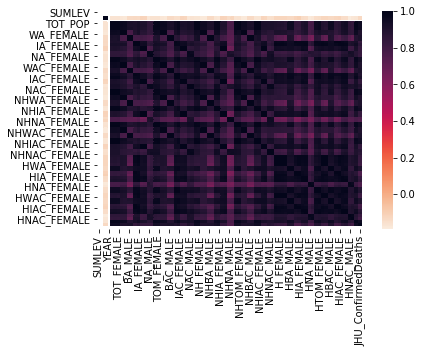

In [20]:
sns.heatmap(test.corr(), cmap = sns.cm.rocket_r)
plt.show()

In [21]:
test.corr()

,SUMLEV,STATE,COUNTY,YEAR,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,...,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE,JHU_ConfirmedCases,JHU_ConfirmedDeaths,JHU_ConfirmedRecoveries
SUMLEV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STATE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
COUNTY,NaN,NaN,1.000000,NaN,-0.162043,-0.161893,-0.162155,-0.171864,-0.172712,-0.132512,...,-0.128751,-0.117407,-0.113915,-0.141732,-0.143579,-0.186314,-0.170232,-0.165984,-0.130619,NaN
YEAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TOT_POP,NaN,NaN,-0.162043,NaN,1.000000,0.999899,0.999909,0.963015,0.959078,0.921365,...,0.958544,0.866511,0.877831,0.934290,0.945263,0.855257,0.840925,0.986946,0.958538,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HNAC_MALE,NaN,NaN,-0.186314,NaN,0.855257,0.856317,0.854096,0.853618,0.852408,0.737540,...,0.846119,0.878799,0.893076,0.893648,0.891544,1.000000,0.985996,0.885663,0.827393,NaN
HNAC_FEMALE,NaN,NaN,-0.170232,NaN,0.840925,0.842581,0.839202,0.850508,0.849449,0.705634,...,0.848838,0.894108,0.910684,0.905343,0.901520,0.985996,1.000000,0.873309,0.800225,NaN
JHU_ConfirmedCases,NaN,NaN,-0.165984,NaN,0.986946,0.987766,0.985986,0.960698,0.956314,0.892051,...,0.951088,0.882591,0.900841,0.948112,0.955092,0.885663,0.873309,1.000000,0.959514,NaN
JHU_ConfirmedDeaths,NaN,NaN,-0.130619,NaN,0.958538,0.957229,0.959598,0.905488,0.902307,0.913741,...,0.902448,0.786951,0.801513,0.867091,0.880339,0.827393,0.800225,0.959514,1.000000,NaN


In [14]:
test[['HWAC_MALE','JHU_ConfirmedCases']].corr()

,HWAC_MALE
HWAC_MALE,1.0


In [15]:
test.dtypes

SUMLEV                      int64
STATE                       int64
COUNTY                      int64
STNAME                     object
CTYNAME                    object
                            ...  
HNAC_FEMALE                 int64
parent.id                  object
JHU_ConfirmedCases         object
JHU_ConfirmedDeaths        object
JHU_ConfirmedRecoveries    object
Length: 84, dtype: object